# A practical guide to the `hsclens` pipeline

## Overview

The goal of the `hsclens` pipeline is to constrain the cosmological and astrophysical parameters by comparing the real weak lensing catalogues to the mock catalogs from simulations. In this notebook, I will introduce the code and scripts that need to be run to do the analysis. For a detailed decription of the pipeline, see the paper [Cosmological constraints from HSC survey first-year data using deep learning](https://arxiv.org/abs/2301.01354).

## Prerequisites

### `pkdgrav3`

`pkdgrav3` is a high performance cosmological simulation code. Clone the repository from [dpotter/pkdgrav3](https://bitbucket.org/dpotter/pkdgrav3/src/master/), and build the binary following the steps in README. `pkdgrav3` depends on CMake, Python3, GSL, and FFTW. In my build, these three lines in `build/pkd_config.h` are commented:
```c++
/* #undef USE_CUDA */
/* #undef INTEGER_POSITION */
/* #undef POTENTIAL_IN_LIGHTCONE */
```

### `MUSIC`

`MUSIC` generates initial conditions for the cosmological simulations. Clone the repository from [ohahn/music](https://bitbucket.org/ohahn/music/src/master/), and build the binary following the steps in README. `MUSIC` depends on FFTW, GSL, and HDF5.

### `rockstar`

`rockstar` is a halo finder. Clone the repository from [dpotter/pkdgrav3](https://bitbucket.org/dpotter/pkdgrav3/src/master/), and build the binary with `make`. In my pipeline, `rockstar` will read the *N*-body snapshots in TIPSY format, and produces halo catalogues in ASCII and binary formats.

### `hsclens`

`hsclens` processes and analyzing *N*-body and halo data. It can produce mock weak lensing catalogues based on the simulations and the real catalogues. The source code of `hsclens` is under the current directory (`main.cpp` and `utils.h`). To compile `hsclens` with icc on Stampede2/Frontera, run
```bash
module load intel/19 impi
icpc -Wall -Ofast -g -xCORE-AVX512 -std=c++17 -fopenmp -I$MKLROOT/include/fftw -o hsclens main.cpp -mkl -lz -lstdc++fs
```


The usage of `hsclens` typically looks like:
```bash
hsclens <task> <more_arguments...>
```

## *N*-body simulation

### Calculate simulated cosmologies and snapshot schedule

For HSC Y1, I choose the following 79 cosmologies where the simulation are run. The cosmologies are arranged along 7 constant $S_8=\sigma_8(\Omega_m/0.3)^{0.5}$ curves ($0.662\le S_8\le0.966$). 

In [7]:
import functools, numpy as np
cosmologies = [[
    [0.3 * ((1 + 0.048 * j) ** 3.22) * (0.985 ** i), 0.8 * (1.065 ** i)]
    for j in range(-6 + max(i, 0), 7 + min(i, 0))]
    for i in range(-3, 4)]
cosmologies = functools.reduce(lambda x,y: x + y, cosmologies, [])
cosmologies = np.array([[x[0], x[1] / np.sqrt(x[0]/0.3)] for x in cosmologies])
cosmologies = np.array([[x[0], 1 - x[0], x[1]] for x in np.round(cosmologies[np.argsort(cosmologies[:,0])],4)])

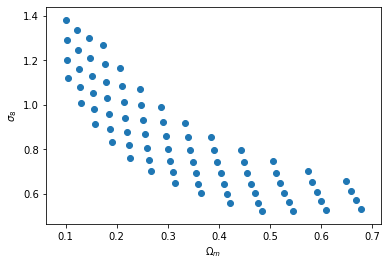

In [9]:
import matplotlib.pyplot as plt
plt.scatter(cosmologies[:,0], cosmologies[:,2])
plt.xlabel("$\Omega_m$"), plt.ylabel("$\sigma_8$")
plt.show()

While a simulation is running, we ask `pkdgrav3` to take snapshots at certain redshifts to perform raytracing later. In my pipeline, I choose the redshifts so that the comoving distance between two adjcent snapshots is $120\,\mathrm{Mpc/h}$.

In [ ]:
import astropy.units, astropy.cosmology
h0, Om0 = 0.6736, 0.3000
zlist = list(map(lambda x: astropy.cosmology.z_at_value(
    astropy.cosmology.FlatLambdaCDM(H0=100 * h0, Om0=Om0).comoving_distance, x),
    np.arange(60, 4870, 120) * astropy.units.Mpc / h0))
zlist.insert(0, 0.00001)
print("\n".join(["z{:1.5f}".format(z) for z in zlist]))

The redshift schedule is stored in `./pkdgrav3_sims/template_Om0.0000_si0.0000_1024_500/snapshots/snapshot.red`, which will be copied to the directory for each simulation. If you want to use a different schedule, replace the content before preparing the directories.

### Prepare config files and job scripts

In my workflow, the config files and job scripts for each simulation are identical except for the cosmology. `./pkdgrav3_sims/template_Om0.0000_si0.0000_1024_500` stores the template config files and job scripts assuming the number of particles being $N_p=1024^3$ and box size $500\,\mathrm{(Mpc/h)^3}$.

In my workflow, the simulations are organized with the following structure:
```
-- <simulation_directory>/
    |-- sim_Om0.1005_si1.3823_1024_500/
         |-- halos/         # halo finder results
         |-- ics/           # initial condition
         |-- snapshots/     # simulation snapshots
         |-- cosmology.par  # simulation parameters
         |-- halo.slurm     # halo finder job script
         |-- job.slurm      # simulation job script
         |-- ...
    |-- sim_Om0.1020_si1.2881_1024_500/
    |-- ...
    |-- sim_Om0.6777_si0.5323_1024_500/
```
The name of each subdirectory is the form of `sim_Om<Omega_m>_si<sigma_8>_<grid_size>_<physical_size>`.

`./pkdgrav3_sims/prepare_sim.sh` is a script to prepare each of the subdirectories. Before using `prepare_sim.sh`, you should set `PKDGRAV3_PATH` and `MUSIC_PATH` in this script to your `pkdgrav3` and `MUSIC` paths, and you should check other cosmological parameters (the same across all simulations) defined in `prepare_sim.sh`. If you want to change the number of particles or the box size, I suggest you to make a copy of the template configs and scripts (renaming the `_1024_500` part) and check each of the configs and scripts to make sure they are correct, and change the constants in `main.cpp` for `hsclens`.

If you want to create a subdirectory under `.../my_simulations/` for the fiducial cosmology ($\Oemga_m=0.8$, $\sigma_8=0.8$) so that you can run the simulations on Stampede2's `skx-normal` queue (48 cores per node). You can run:
```bash
cd .../my_simulations/
bash <repo_path>/pkdgrav3_sims/prepare_sim.sh 0.3000 0.7000 0.8000 skx-normal 48
```
, where `<repo_path>` is the path to this repository.

And to get the commands for all cosmologies we calculated before, run the following Python code:

In [ ]:
for i in range(len(cosmologies)):
    print("bash <repo_path>/pkdgrav3_sims/prepare_sim.sh {:1.4f} {:1.4f} {:1.4f} skx-normal 48".format(*cosmologies[i]))

: 

### Run job scripts

To start an *N*-body simulation, execute
```bash
sbatch job.slurm
```

By default, `job.slurm` sets the job time to be 48 hours, which is enough to finish any of the simulations with the default particle number and box size on Stampede2. It may take a shorter time to finish on Frontera.

To run the halo finder, execute
```bash
sbatch halo.slurm
```

By default, `halo.slurm` sets the job time to be 10 hours. Sometimes, it may not be enough or may be interrupted, and in those cases, you can submit the job again and the halo finder will start from where it was interrupted.

## Density slabs and BCM

### Slab configurations

The lensing signals are raytraced through the density slabs cut from the snapshots. To speed up the process, we cut all the slabs before any raytracing and store their column density maps together with the halo information. 

The exactly slab configurations (thickness, comoving distance, etc.) for each cosmology varies. Here, we generate a `slab.config` file that contains those configuations in each simulation subdirectory. To do this, change the working directory to be one of the simulations, e.g. `sim_Om0.3000_si0.8000_1024_500/`, and run
```bash
python <repo_path>/generate-slab-config.py
```
`generate-slab-config.py` will combine the cosmology from the directiry name and `snapshots.red` to do the calculation. By default, $h_0=0.6736$ (Planck 2018) and $z_\mathrm{max}=3.0$ is used, which can be modified in the script. 

### Density maps

With `slab.config` ready, run
```bash
<repo_path>/hsclens calc_density_maps ./slab.config ./halos/ ./density/ 3e12
```
to calculate and save the slab and halo information to `./density/`, where `3e12` means that the halo mass threshold is $3\times10^{12}\mathrm{M}_\odot$.

### BCM

The baryons are added to the halos with BCM. We pre-compute the BCM patches so that they can be painted onto halos faster. To generate the BCM patches, run
```bash
<repo_path>/hsclens calc_bcm_patches <bcm_patches_output_dir>
```
, and the data are saved in `<bcm_patches_output_dir>`.

## The HSC catalog

### Download

The HSC Y1 shape catalog can be queried from [HSC PDR](https://hsc-release.mtk.nao.ac.jp/datasearch/) with
```sql
select
    b.*, a.ishape_hsm_regauss_e1, a.ishape_hsm_regauss_e2, a.ishape_hsm_psfmoments_11, a.ishape_hsm_psfmoments_22, a.ishape_hsm_psfmoments_12, c.ira, c.idec, d.photoz_best
from
    s16a_wide.meas2 a
    inner join s16a_wide.weaklensing_hsm_regauss b using (object_id)
    inner join s16a_wide.meas c using (object_id)
    inner join s16a_wide.photoz_ephor_ab d using (object_id)
```
The result from my job is stored at `/work2/06005/tg853047/stampede2/hsc-baryon/catalog/s16a-catalog.csv`.

The files for photo-*z* calibration can be downloaded from

1. [pdf-s17a_wide-9812.cat](https://hsc-release.mtk.nao.ac.jp/archive/filetree/cosmos_photoz_catalog_reweighted_to_s16a_shape_catalog/ephor_ab/pdf-s17a_wide-9812.cat.fits)
2. [pdf-s17a_wide-9813.cat](https://hsc-release.mtk.nao.ac.jp/archive/filetree/cosmos_photoz_catalog_reweighted_to_s16a_shape_catalog/ephor_ab/pdf-s17a_wide-9813.cat.fits)
3. [Afterburner_reweighted_COSMOS_photoz_FDFC](https://hsc-release.mtk.nao.ac.jp/archive/filetree/cosmos_photoz_catalog_reweighted_to_s16a_shape_catalog/Afterburner_reweighted_COSMOS_photoz_FDFC.fits)

They can be accessed from `/work2/06005/tg853047/stampede2/hsc-baryon/catalog/`.

### Process

Run the following python code to process the HSC catalog. 

Note that the raytracing redshift $z_\mathrm{rt}$ will be randomly sampled, so they are not preserved after regeneration of the catalogs. The processed catalogs and masks used in the paper can be accessed from `/work2/06005/tg853047/stampede2/hsc-baryon/catalog/`.

In [ ]:
import pandas as pd
s16a = pd.read_csv(".../s16a-catalog.csv", index_col=0, header=None, comment="#",
    names="id,w,m,c1,c2,sigma_e,rms_e,e1,e2,psf_m11,psf_m22,psf_m12,ra,dec,z_best".split(","))

In [ ]:
z_bins = np.array([[0.3, 0.6], [0.6, 0.9], [0.9, 1.2], [1.2, 1.5]])
for i in np.arange(4):
    s16a.loc[(z_bins[i,0] <= s16a["z_best"]) & (s16a["z_best"] < z_bins[i,1]), "z_bin"] = i

In [ ]:
from astropy.io import fits
with fits.open("./data/pdf-s17a_wide-9812.cat.fits") as data:
    z9812 = pd.DataFrame({"id": data[1].data["ID"],"z_best": data[1].data["PHOTOZ_BEST"]})
with fits.open("./data/pdf-s17a_wide-9813.cat.fits") as data:
    z9813 = pd.DataFrame({"id": data[1].data["ID"],"z_best": data[1].data["PHOTOZ_BEST"]})
z_ephor_ab = pd.concat([z9812, z9813], axis=0, ignore_index=True)
del z9812, z9813
with fits.open("./data/Afterburner_reweighted_COSMOS_photoz_FDFC.fits") as data:
    z_cosmos = pd.DataFrame({
        "id": data[1].data["S17a_objid"].astype("i8"),
        "z_cosmos": data[1].data["COSMOS_photoz"].astype("f8"),
        "w_som": data[1].data["SOM_weight"].astype("f8")
    })
z_mapping = pd.merge(z_ephor_ab, z_cosmos, how="inner", on="id")

In [ ]:
from scipy import stats
for i in np.arange(4):
    selected = z_mapping[(z_bins[i,0] <= z_mapping.z_best) & (z_mapping.z_best < z_bins[i,1]) & (z_mapping.z_cosmos < z_bins[i,1] + 1.2)]
    kde = stats.gaussian_kde(selected["z_cosmos"], bw_method=0.03, weights=selected["w_som"])
    samples = kde.resample((s16a["z_bin"] == i).sum())[0]
    s16a.loc[s16a["z_bin"] == i, "z_rt"] = np.sort(samples)[np.argsort(np.argsort(s16a.loc[s16a["z_bin"] == i, "z_best"]))]
    print(f"z_bin={i:d}, min={np.min(samples):1.4f}, max={np.max(samples):1.4f}, mean={np.mean(samples):1.4f}, median={np.median(samples):1.4f}, std={np.std(samples):1.4f}")

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
for i in range(4):
    plt.hist(s16a.loc[s16a["z_bin"] == i, "z_rt"], bins=250, range=(0,2.5), density=True, label=f"z_bin={i:d}", histtype="step")
    plt.axvspan(z_bins[i,0], z_bins[i,1], alpha=0.1, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
plt.legend()
plt.show()

In [ ]:
fieldBounds = np.array([
    [[29.8,32.8],[-5.8,-2.8]],[[32.8,35.8],[-6.0,-3.0]],[[35.8,38.8],[-5.8,-2.8]],
    [[128.9,131.9],[-0.5,2.5]],[[131.9,134.9],[-0.5,2.5]],[[134.9,137.9],[-0.1,2.9]],[[137.9,140.9],[-1.0,2.0]],
    [[176.4,179.4],[-1.7,1.3]],[[179.4,182.4],[-1.7,1.3]],
    [[210.3,213.3],[-1.7,1.3]],[[213.3,216.3],[-1.7,1.3]],[[216.3,219.3],[-1.7,1.3]],[[219.3,222.3],[-1.7,1.3]],[[222.3,225.3],[-1.7,1.3]],
    [[239.13,243.3],[41.9,44.9]],[[243.3,247.47],[41.9,44.9]],
    [[331.8,334.8],[-0.8,2.2]],[[334.8,337.8],[-0.8,2.2]],[[337.8,340.8],[-0.8,2.2]]
])
fieldCenters = np.mean(fieldBounds, axis=-1)

def getXY(ra0, dec0, ra, dec):
    deg = np.pi / 180.0
    r0, d0 = ra0 * deg, dec0 * deg
    r = ra * deg
    d = dec * deg
    l = np.sin(d0) * np.sin(d) + np.cos(d0) * np.cos(d) * np.cos(r - r0)
    x = (np.cos(d) * np.sin(r - r0)) / l
    y = (np.cos(d0) * np.sin(d) - np.sin(d0) * np.cos(d) * np.cos(r - r0)) / l
    return (x / deg, y / deg)

In [ ]:
s16aFields = []
for i in range(len(fieldBounds)):
    bounds = fieldBounds[i]
    field = s16a.loc[(bounds[0,0] < s16a.ra) & (s16a.ra < bounds[0,1]) & (bounds[1,0] < s16a.dec) & (s16a.dec < bounds[1,1])].copy()
    x, y = getXY(fieldCenters[i][0], fieldCenters[i][1], field.ra.values, field.dec.values)
    field["field"], field["x"], field["y"] = np.full_like(x, i, dtype="i4"), x, y
    field["m_bias"] = np.array([0.0086,0.0099,0.0241,0.0391,0.0])[np.nan_to_num(field["z_bin"].values, nan=4.0).astype("i")]
    field = field.loc[(-1.5 < field.x) & (field.x < 1.5) & (-1.5 < field.y) & (field.y < 1.5) & field.z_bin.notna()]
    field = field.astype({"z_bin": "int"})
    s16aFields.append(field)

In [ ]:
# Uncomment the next two lines to save the catalogs to files (make sure the files names are correct!)
# for i in range(len(s16aFields)):
#     s16aFields[i].to_csv(f".../s16a-catalog-field{i+1:02d}.csv")

In [ ]:
from scipy import ndimage
def getCounts(df, bins=1024, range=[[-1.5,1.5],[-1.5,1.5]]):
    hist = np.histogram2d(df.x.values, df.y.values, bins=bins, range=range)[0]
    return hist.astype("f8")

def getBinaryMask(counts, radius=2.0, threshold=0.15, reduction=1):
    mask = ndimage.gaussian_filter((counts > 0).astype("float"), radius) > threshold
    size = mask.shape[0]
    assert size % reduction == 0
    return np.swapaxes(mask.reshape((size // reduction, reduction, size // reduction, reduction)), 1, 2).mean(axis=(2,3)).astype("f4")

for i in range(len(s16aFields)):
    size = 208
    mask = getBinaryMask(getCounts(s16aFields[i], bins=size*5), 2.0, 0.175, 5)
    # Uncomment the next line to save the masks to files (make sure the files names are correct!)
    # mask.astype("f4").tofile(f".../s16a-mask-size{size}-field{i+1:02d}.f32")

## Raytracing

Raytracing generates weak lensing shear maps and intrinsic alignment maps from density maps and halo information, with command
```bash
hsclens calc_hsc_ray_tracing <slab_config> <density_dir> <raytracing_dir> <catalog_dir> <bcm_patches_dir> <baryon_model> <num_realizations> <first_seed>
```
The meaning of the arguments are:
- `<slab_config>`: the path to `slab.config`
- `<density_dir>`: the path to `density/`
- `<raytracing_dir>`: the path to `raytracing/` (the output directory)
- `<catalog_dir>`: the path to the processed HSC catalogs and masks
- `<bcm_patches_dir>`: the path to the BCM patches
- `<baryon_model>`: one of `fiducial`, `free`, or `none`
- `<num_realizations>`: number of realizations to be generated
- `<first_seed>`: the random seed of the first realization

The output files for each command are:
1. `sim-wg-allfields.<first_seed>.<num_realizations>.c64`: non-tomographic WL map ($\sum_i w_ig_i$ for each pixel)
2. `sim-wg-tomo-allfields.<first_seed>.<num_realizations>.c64`: tomographic WL map ($\sum_i w_ig_i$ for each pixel)

In my workflow, I set `<num_realizations>=10`, and run 4 `hsclens` raytracing processes in parallel on one node, where each process uses 12 threads. With this configuration, 400 realizations can be generated per hour per node on Stampede2. To speed up the reading of the catalogs and BCM patches, I recommend copying them to `/dev/shm/` at the beginning of the jobs.

Here is an example job script to do raytracing, where I generate 800 realizations for the fiducial cosmology. (You can also use TACC's `launcher` to run raytracing for all cosmologies with one job.)
```bash
#!/bin/bash
#SBATCH -J raytrace
#SBATCH -o raytrace.o%j
#SBATCH -e raytrace.e%j
#SBATCH -p skx-normal
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -t 03:00:00

ml intel/19 impi
export OMP_NUM_THREADS=12
cp -r $WORK2/../stampede2/hsc-baryon/catalog/ /dev/shm/
cp -r $WORK2/../stampede2/hsclens/bcm_patches/ /dev/shm/
date && cd /scratch/06005/tg853047/pkdgrav3_sims/sim_Om0.3000_si0.8000_1024_500 && (seq 0 10 799 | xargs -n1 -P4 $WORK2/hsclens/hsclens calc_hsc_ray_tracing slab.config ./density/ ./raytracing/ /dev/shm/catalog/ /dev/shm/bcm_patches/ free 10 > output.log) && date
```

## Statistics

To be finished...